<a href="https://colab.research.google.com/github/navneedh/compression-ml/blob/master/robustness_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
root = "/content/drive/MyDrive/"
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/compression-ml/

/content/drive/MyDrive/compression-ml


In [ ]:
%reload_ext autoreload
%autoreload 2

from fastprogress import master_bar, progress_bar

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os 
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
from scipy.stats import entropy

 
from cifar_models import *
from m_utils.dataset import *
from m_utils.image_utils import *
from cifar_models.vgg import *
from cifar_models.resnet import *
device = "cuda" if torch.cuda.is_available() else "cpu"

plt.rcParams["font.family"] = "serif"
plt.rcParams['font.size'] = 13

In [ ]:
def pytorch_count_params(model):
  "count number trainable parameters in a pytorch model"
  total_params = sum(reduce( lambda a, b: a*b, x.size()) for x in model.parameters())
  return total_params

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]
)

## Test on Noisy CIFAR Data 


In [ ]:
saved_models_folder = "saved_models"
results_folder = "exp_results"
BATCH_SIZE = 128

In [ ]:
cifar_deformations = ["gaussian_noise", "gaussian_blur", "speckle_noise", "contrast", "impulse_noise", "saturate", "brightness"]
cifar_natural_deformations = ['fog', 'frost', 'snow']
bls_models = ["bls001","bls003","bls005","bls012","bls033", "bls05", "bls1"]
gn_models = ["gn0.01", "gn0.05", "gn0.1","gn0.3","gn0.8","gn1"]
glp_models = ["glp3", "glp5", "glp7", "glp9"]
jpeg_models = ["jpeg1", "jpeg5","jpeg10","jpeg20","jpeg40", "jpeg60", "jpeg80"]

#### Calculate Clean Accuracies

In [ ]:
bls_clean_accs = []
gn_clean_accs = []
glp_clean_accs = []
jpeg_clean_accs = []

for model in bls_models:
  bls_clean_accs.append(np.load(os.path.join(results_folder, "{}.npz".format(model)))['test_acc'].max())

for model in gn_models:
  gn_clean_accs.append(np.load(os.path.join(results_folder, "{}.npz".format(model)))['test_acc'].max())

for model in glp_models:
  glp_clean_accs.append(np.load(os.path.join(results_folder, "{}.npz".format(model)))['test_acc'].max())

for model in jpeg_models:
  jpeg_clean_accs.append(np.load(os.path.join(results_folder, "{}.npz".format(model)))['test_acc'].max())

In [ ]:
def test(testloader):
    softmax_output = nn.Softmax()
    criterion = nn.CrossEntropyLoss()
    metrics = []
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    # entropies = []
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets.long())
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            # entropies.extend(entropy(outputs.detach().cpu().numpy(), axis = 1))
        return correct/total, test_loss/(10000/BATCH_SIZE) #, entropies



# test_acc, test_loss, test_entropies = test(test_loader)

# np.savez("/content/drive/MyDrive/compression-ml/exp_results/robustness_results/{}.npz".format(exp_name), test_acc=test_acc, test_entropy=test_entropies)

#### Experimental Model Performance on Noisy Datasets

In [ ]:
for deformation in progress_bar(cifar_natural_deformations + cifar_deformations):
  for model in ["wloss_base14"]:
    vals = []
    exp_name = "_".join([model, deformation]) 
    for level in range(5):
      test_dset = CifarCDataset(deformation, transform_level=level, data_transform = transform)
      test_loader = DataLoader(test_dset, batch_size = BATCH_SIZE, shuffle = False)
      net = VGG('VGG11').to(device)
      net.load_state_dict(torch.load(os.path.join(saved_models_folder, model + ".pt"), map_location=torch.device('cpu')))
      test_acc, test_loss = test(test_loader)
      vals.append(test_acc)
    np.savez("/content/drive/MyDrive/compression-ml/exp_results/robustness_results/{}.npz".format(exp_name), test_acc=vals)      

#### Baseline Model Performance on Noisy Datasets


In [ ]:
for deformation in progress_bar(cifar_natural_deformations):
  vals = []
  exp_name = "_".join(["base", deformation]) 
  print(exp_name)
  for level in range(5):
    test_dset = CifarCDataset(deformation, transform_level=level, data_transform = transform)
    test_loader = DataLoader(test_dset, batch_size = BATCH_SIZE, shuffle = False)
    net = VGG('VGG11').to(device)
    net.load_state_dict(torch.load(os.path.join(saved_models_folder, "base.pt"), map_location=torch.device('cpu')))
    test_acc, test_loss = test(test_loader)
    vals.append(test_acc)
  np.savez("/content/drive/MyDrive/compression-ml/exp_results/robustness_results/{}.npz".format(exp_name), test_acc=vals)      

base_fog


KeyboardInterrupt: ignored

# Max Accuracy across all deformations and severity levels

In [ ]:
# Find data set that provides best average performance across all deformations and levels
glp_top_models = [0,1,2,3]
jpeg_top_models = [6, 3, 5, 2, 4, 1, 0]
bls_top_models = [3,6,5,4,1,0,2]
gn_top_models = [0,1,2,3,5,4]

#For each deformation, select training data that provides best avg performance across data degradation levels 
bls_best_models = [5, 6, 3, 6, 5, 4, 4, 3, 6, 4]
jpeg_best_models = [3, 1, 3, 5, 3, 6, 6, 6, 6, 6]
gn_best_models = [1, 0, 1, 0, 2, 0, 0, 0, 0, 0]
glp_best_models = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

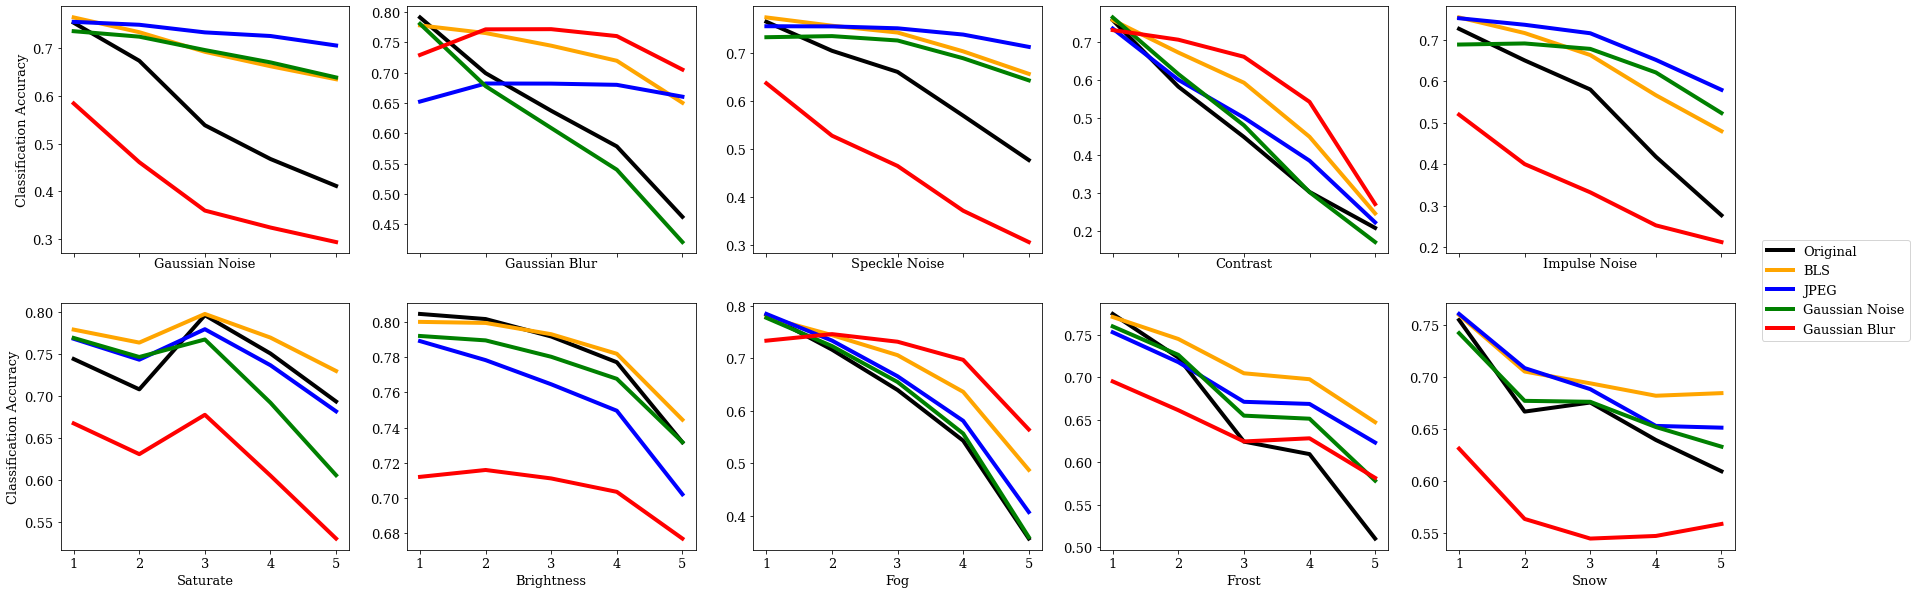

In [ ]:
bls_best_models = []
gn_best_models = []
glp_best_models = []
jpeg_best_models = []

bls_data = []
glp_data = []
gn_data = []
jpeg_data = []
base_data = []

bls_avg_accs = []
glp_avg_accs = []
gn_avg_accs = []
jpeg_avg_accs = []

fig, axs = plt.subplots(2,5, figsize = (30,10), sharex="col")

img_idx = [(0,0),(0,1),(0,2),(0,3),(0,4),(1,0),(1,1),(1,2),(1,3),(1,4)]

for i, deformation in enumerate(cifar_deformations + cifar_natural_deformations):
  base_clean_acc = np.load("exp_results/base.npz".format(deformation))['test_acc'].max()
  base_data.append(np.load("exp_results/robustness_results/base_{}.npz".format(deformation))['test_acc'])

  axs[img_idx[i]].plot(range(1,6), ( np.load("exp_results/robustness_results/base_{}.npz".format(deformation))['test_acc']), "-", linewidth = 4, color = "black", label = "Original")
  all_accs = []
  for model in bls_models:
    exp_name = "_".join([model, deformation]) 
    results = np.load("exp_results/robustness_results/{}.npz".format(exp_name))
    all_accs.append(results['test_acc'])
  all_accs = np.array(all_accs)
  max_ind = 3
  # max_ind = np.argmax(all_accs.mean(axis = -1))
  bls_best_models.append(max_ind)
  bls_data.append(all_accs[max_ind])
  axs[img_idx[i]].plot(range(1,6), all_accs[max_ind], linewidth = 4, color = "orange", label = "BLS (0.012)")

  all_accs = []
  for model in jpeg_models:
    exp_name = "_".join([model, deformation]) 
    results = np.load("exp_results/robustness_results/{}.npz".format(exp_name))
    all_accs.append(results['test_acc'])
  all_accs = np.array(all_accs)
  max_ind = 6
  # max_ind = np.argmax(all_accs.mean(axis = -1))
  jpeg_best_models.append(max_ind)
  jpeg_data.append(all_accs[max_ind])
  axs[img_idx[i]].plot(range(1,6), all_accs[max_ind], linewidth = 4, color = "blue", label = "JPEG (80)")

  all_accs = []
  for model in gn_models:
    exp_name = "_".join([model, deformation]) 
    results = np.load("exp_results/robustness_results/{}.npz".format(exp_name))
    all_accs.append(results['test_acc'])
  all_accs = np.array(all_accs)
  max_ind = 0
  # max_ind = np.argmax(all_accs.mean(axis = -1))
  gn_best_models.append(max_ind)
  gn_data.append(all_accs[max_ind])
  axs[img_idx[i]].plot(range(1,6), all_accs[max_ind], linewidth = 4, color = "green", label = "Gaussian Noise (0.01)")

  all_accs = []
  for model in glp_models:
    exp_name = "_".join([model, deformation]) 
    results = np.load("exp_results/robustness_results/{}.npz".format(exp_name))
    all_accs.append(results['test_acc'])
  all_accs = np.array(all_accs)
  max_ind = 0
  # max_ind = np.argmax(all_accs.mean(axis = -1))
  glp_best_models.append(max_ind)
  glp_data.append(all_accs[max_ind])
  axs[img_idx[i]].plot(range(1,6), all_accs[max_ind], linewidth = 4, color = "red", label = "Gaussian Blur (3x3)")

  axs[img_idx[i]].set_xlabel(deformation.replace("_", " ").title())

axs[0,0].set_ylabel("Classification Accuracy")
axs[1,0].set_ylabel("Classification Accuracy")
plt.legend(loc = "center", bbox_to_anchor=(1.35, 1.05))
plt.savefig("all_max.png")

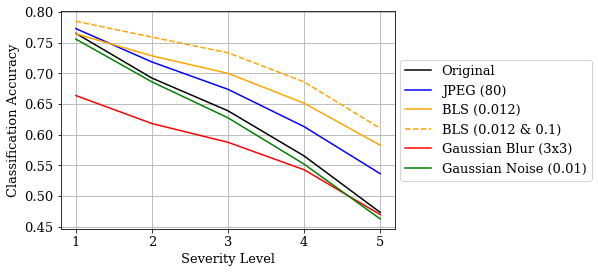

In [ ]:
plt.plot(range(1,6), np.array(base_data).mean(axis = 0), color = "black", label = "Original")
plt.plot(range(1,6), np.array(jpeg_data).mean(axis = 0), color = "blue", label = "JPEG (80)")
plt.plot(range(1,6), np.array(bls_data).mean(axis = 0), color = "orange", label = "BLS (0.012)")
plt.plot(range(1,6), np.array(new_bls_accs).mean(axis =0), color = "orange", linestyle = "dashed", label = "BLS (0.012 & 0.1)")
plt.plot(range(1,6), np.array(glp_data).mean(axis = 0), color = "red", label = "Gaussian Blur (3x3)")
plt.plot(range(1,6), np.array(gn_data).mean(axis = 0), color = "green", label = "Gaussian Noise (0.01)")

leg = plt.legend(loc = "center", bbox_to_anchor=(1.3, 0.5))

plt.grid()
plt.xlabel("Severity Level")
plt.ylabel("Classification Accuracy")
plt.savefig("dataaug_max_avg.png", bbox_extra_artists=[leg], bbox_inches='tight')

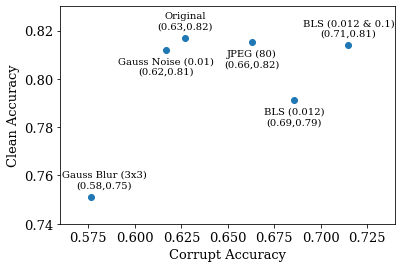

In [ ]:
wbase14_clean_acc = np.load("exp_results/robustness_results/wloss_base14.npz")['test_acc'].max()


deg_accuracy = [np.array(bls_data).mean(), np.array(jpeg_data).mean(), np.array(base_data).mean(), np.array(gn_data).mean(),  np.array(glp_data).mean(), np.array(new_bls_accs).mean()]
clean_accuracy = [bls_clean_accs[3], jpeg_clean_accs[6], base_clean_acc, gn_clean_accs[0], glp_clean_accs[0], wbase14_clean_acc]
labels = ["BLS (0.012)", "JPEG (80)", "Original", "Gauss Noise (0.01)", "Gauss Blur (3x3)", "BLS (0.012 & 0.1)"]
shifts = [(0, -0.01), (0, -0.01), (0, 0.004), (0, -0.01), (0.007, 0.004), (0, 0.004)]

fig, ax = plt.subplots(figsize = (6,4))
ax.scatter(deg_accuracy, clean_accuracy)
ax.set_ylabel("Clean Accuracy")
ax.set_xlabel("Corrupt Accuracy")
ax.set_ylim([0.74, 0.83])
ax.set_xlim([0.56, 0.74])

for i, txt in enumerate(labels):
    
    ax.annotate("{}\n({:1.2f},{:1.2f})".format(txt,deg_accuracy[i],clean_accuracy[i]), (deg_accuracy[i], clean_accuracy[i]), xytext = (deg_accuracy[i] + shifts[i][0], clean_accuracy[i] + shifts[i][1]), fontsize = 10,ha='center')


plt.savefig("deg_vs_clean.png")

### Max accuracy per deformation type

In [ ]:
bls_data = []
glp_data = []
gn_data = []
jpeg_data = []

for deformation in cifar_deformations + cifar_natural_deformations:
  all_accs = []
  for model in bls_models:
    exp_name = "_".join([model, deformation]) 
    results = np.load("exp_results/robustness_results/{}.npz".format(exp_name))
    all_accs.append(results['test_acc'])
  all_accs = np.array(all_accs)
  max_ind = np.argmax(all_accs.mean(axis = -1))
  bls_data.append(all_accs[max_ind])

  all_accs = []
  for model in jpeg_models:
    exp_name = "_".join([model, deformation]) 
    results = np.load("exp_results/robustness_results/{}.npz".format(exp_name))
    all_accs.append(results['test_acc'])
  all_accs = np.array(all_accs)
  max_ind = np.argmax(all_accs.mean(axis = -1))
  jpeg_data.append(all_accs[max_ind])

  all_accs = []
  for model in gn_models:
    exp_name = "_".join([model, deformation]) 
    results = np.load("exp_results/robustness_results/{}.npz".format(exp_name))
    all_accs.append(results['test_acc'])
  all_accs = np.array(all_accs)
  max_ind = np.argmax(all_accs.mean(axis = -1))
  gn_data.append(all_accs[max_ind])

  all_accs = []
  for model in glp_models:
    exp_name = "_".join([model, deformation]) 
    results = np.load("exp_results/robustness_results/{}.npz".format(exp_name))
    all_accs.append(results['test_acc'])
  all_accs = np.array(all_accs)
  max_ind = np.argmax(all_accs.mean(axis = -1))
  glp_data.append(all_accs[max_ind])



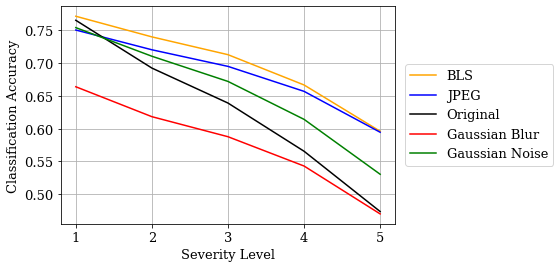

In [ ]:
plt.plot(range(1,6), np.array(bls_data).mean(axis = 0), color = "orange", label = "BLS")
plt.plot(range(1,6), np.array(jpeg_data).mean(axis = 0), color = "blue", label = "JPEG")
plt.plot(range(1,6), np.array(base_data).mean(axis = 0), color = "black", label = "Original",)
plt.plot(range(1,6), np.array(glp_data).mean(axis = 0), color = "red", label = "Gaussian Blur")
plt.plot(range(1,6), np.array(gn_data).mean(axis = 0), color = "green", label = "Gaussian Noise")

leg = plt.legend(loc = "center", bbox_to_anchor=(1.25, 0.5))

plt.grid()
plt.xlabel("Severity Level")
plt.ylabel("Classification Accuracy")
plt.savefig("dataaug_max_avg_deform.png", bbox_extra_artists=[leg], bbox_inches='tight')


# Max accuracy across per level and deformation type

In [ ]:
bls_data = []
glp_data = []
gn_data = []
jpeg_data = []

for deformation in cifar_deformations + cifar_natural_deformations:
  all_accs = []
  for model in bls_models:
    exp_name = "_".join([model, deformation]) 
    results = np.load("exp_results/robustness_results/{}.npz".format(exp_name))
    all_accs.append(results['test_acc'])
  bls_data.append(np.amax(np.array(all_accs), axis = 0))

  all_accs = []
  for model in jpeg_models:
    exp_name = "_".join([model, deformation]) 
    results = np.load("exp_results/robustness_results/{}.npz".format(exp_name))
    all_accs.append(results['test_acc'])
  jpeg_data.append( np.amax(np.array(all_accs), axis = 0))

  all_accs = []
  for model in gn_models:
    exp_name = "_".join([model, deformation]) 
    results = np.load("exp_results/robustness_results/{}.npz".format(exp_name))
    all_accs.append(results['test_acc'])
  gn_data.append( np.amax(np.array(all_accs), axis = 0))

  all_accs = []
  for model in glp_models:
    exp_name = "_".join([model, deformation]) 
    results = np.load("exp_results/robustness_results/{}.npz".format(exp_name))
    all_accs.append(results['test_acc'])
  glp_data.append(np.amax(np.array(all_accs), axis = 0))

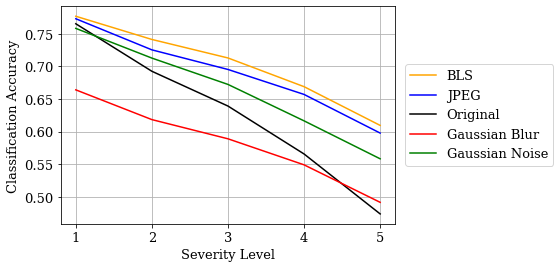

In [ ]:
plt.plot(range(1,6), np.array(bls_data).mean(axis = 0), color = "orange", label = "BLS")
plt.plot(range(1,6), np.array(jpeg_data).mean(axis = 0), color = "blue", label = "JPEG")
plt.plot(range(1,6), np.array(base_data).mean(axis = 0), color = "black", label = "Original",)
plt.plot(range(1,6), np.array(glp_data).mean(axis = 0), color = "red", label = "Gaussian Blur")
plt.plot(range(1,6), np.array(gn_data).mean(axis = 0), color = "green", label = "Gaussian Noise")

leg = plt.legend(loc = "center", bbox_to_anchor=(1.25, 0.5))

plt.grid()
plt.xlabel("Severity Level")
plt.ylabel("Classification Accuracy")
plt.savefig("dataaug_max_avg_max.png", bbox_extra_artists=[leg], bbox_inches='tight')